# Exploratory Data Analysis

This notebook serves to investigate the X-ray images and determine what kind of image processing should be done before training a model.

In [1]:
#Perform necessary imports
import tensorflow as tf 
import numpy as np 
import IPython.display as display
import matplotlib.pyplot as plt

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32

In [3]:
FILENAMES = tf.io.gfile.glob("data/*.tfrec")

print("Train TFRecord Files:", len(FILENAMES))

Train TFRecord Files: 256


In [4]:
#https://keras.io/examples/keras_recipes/tfrecord/

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=1)
    image = tf.cast(image, tf.float32)
    image = tf.reshape(image, [768,768])
    return image

In [5]:
image_feature_description = {
    'image': tf.io.FixedLenFeature([], tf.string),
    'image_id': tf.io.FixedLenFeature([], tf.string),
    'No Finding': tf.io.FixedLenFeature([], tf.int64),
    'Atelectasis': tf.io.FixedLenFeature([], tf.int64),
    'Consolidation': tf.io.FixedLenFeature([], tf.int64),
    'Infiltration': tf.io.FixedLenFeature([], tf.int64),
    'Pneumothorax': tf.io.FixedLenFeature([], tf.int64),
    'Edema': tf.io.FixedLenFeature([], tf.int64),
    'Emphysema': tf.io.FixedLenFeature([], tf.int64),
    'Fibrosis': tf.io.FixedLenFeature([], tf.int64),
    'Effusion': tf.io.FixedLenFeature([], tf.int64),
    'Pneumonia': tf.io.FixedLenFeature([], tf.int64),
    'Pleural_Thickening': tf.io.FixedLenFeature([], tf.int64),
    'Cardiomegaly': tf.io.FixedLenFeature([], tf.int64),
    'Nodule': tf.io.FixedLenFeature([], tf.int64),
    'Mass': tf.io.FixedLenFeature([], tf.int64),
    'Hernia': tf.io.FixedLenFeature([], tf.int64)}



def read_tfrecord(example):
    example = tf.io.parse_single_example(example, image_feature_description)
    image = decode_image(example["image"])
    return image

In [6]:
def load_dataset(filenames):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False  # disable order, increase speed
    dataset = tf.data.TFRecordDataset(
        filenames
    )  # automatically interleaves reads from multiple files
    dataset = dataset.with_options(
        ignore_order
    )  # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [7]:
def get_dataset(filenames):
    dataset = load_dataset(filenames)
    dataset = dataset.shuffle(2048)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

In [8]:
#train_dataset = get_dataset('data/000-438.tfrec')
train_dataset = get_dataset(FILENAMES[0:2])

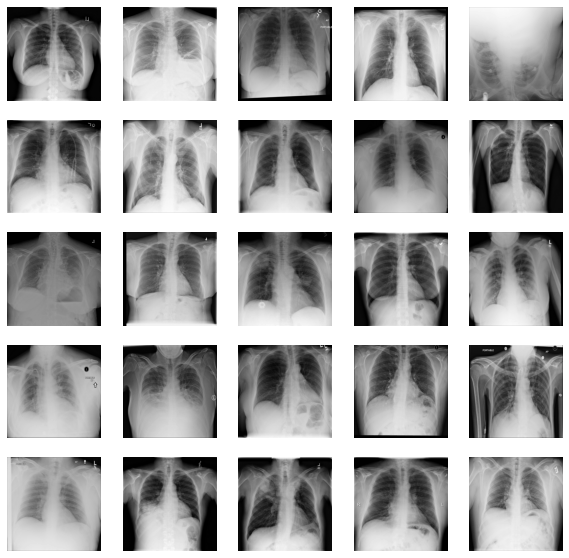

In [9]:
image_batch = next(iter(train_dataset))

def show_batch(image_batch):
    plt.figure(figsize=(10, 10))
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n]/255,cmap='gray')
        plt.axis("off")

show_batch(image_batch.numpy())

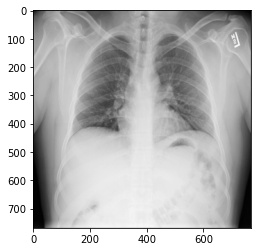

In [10]:
plt.imshow(image_batch[24],cmap='gray')

The image had very low contrast. Let's see if that can be improved.

In [11]:
from skimage import exposure

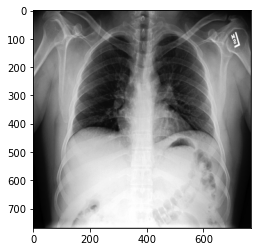

In [12]:
image_eq = exposure.equalize_hist(image_batch[24].numpy()/255)
plt.imshow(image_eq,cmap='gray')

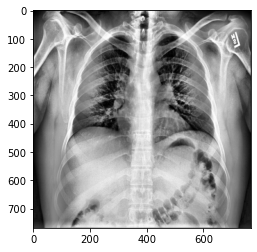

In [13]:
image_eq = exposure.equalize_adapthist(image_batch[24].numpy()/255,clip_limit=0.03)
plt.imshow(image_eq,cmap='gray')

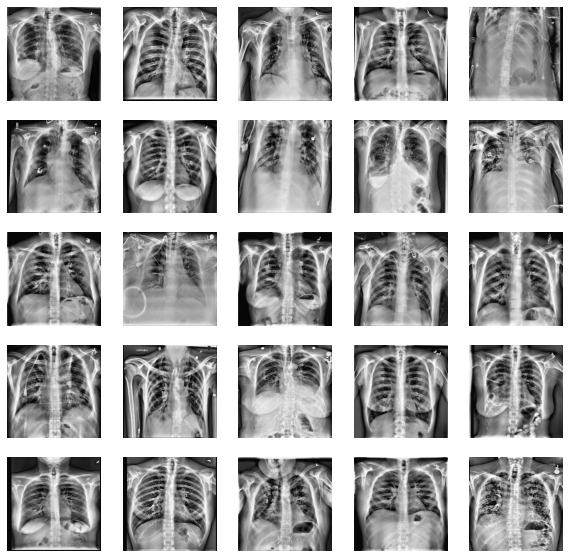

In [16]:
image_batch = next(iter(train_dataset))

def show_batch(image_batch):
    plt.figure(figsize=(10, 10))
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        image_eq = exposure.equalize_adapthist(image_batch[n]/255,clip_limit=0.03)
        plt.imshow(image_eq,cmap='gray')
        plt.axis("off")

show_batch(image_batch.numpy())

The images seem to be much better with adaptive histogram equalization. 